In [287]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
from scipy.ndimage import maximum_filter1d, minimum_filter1d

matplotlib.rcParams['figure.figsize'] = [32, 8]

In [194]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [4]:
REC_MARKER = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 255], dtype=np.uint8)
NUM_SAMPLES = 1024
DATA_DT = np.dtype([('timestamp', np.int64),  # 8 Byte
                    ('n_samples', np.uint16),  # 2 Byte
                    ('rec_num', np.uint16),  # 2 Byte
                    ('samples', ('>i2', NUM_SAMPLES)),  # 2 Byte each x 1024 typ.
                    ('rec_mark', (np.uint8, len(REC_MARKER)))])  # 10 Byte

In [19]:
led = np.fromfile('led.rgb', np.uint8).reshape(-1, 64, 64, 3)
led_yuv = np.fromfile('out.yuv', np.uint8).reshape(-1, 1)

In [20]:
trace = led[:,:,:,2].mean(axis=1).mean(axis=1)

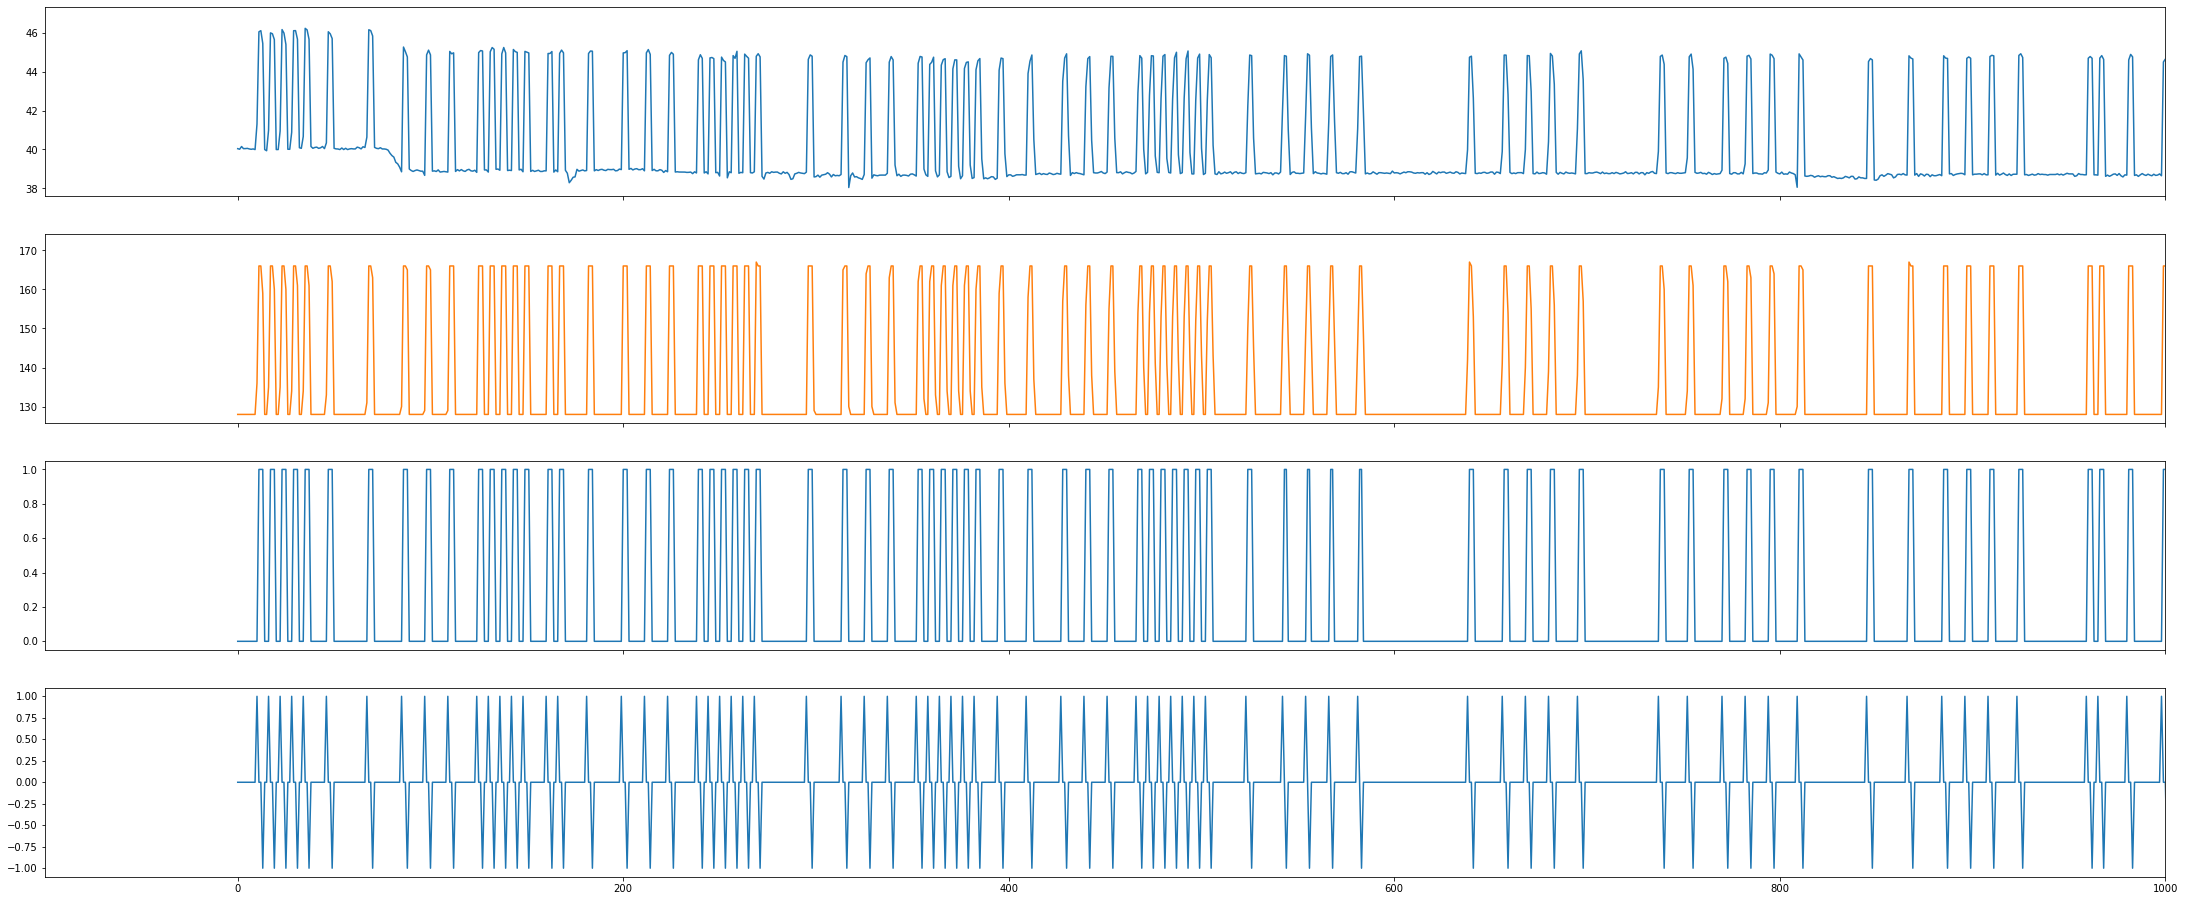

In [21]:
fig, ax = plt.subplots(4, figsize=(38,16), sharex=True)
ax[0].plot(trace)
ax[1].plot(led_yuv, c='C1')
ax[2].plot(trace>42)
ax[3].plot(np.diff((trace>42).astype(float)))
ax[3].set_xlim(-100, 1000);

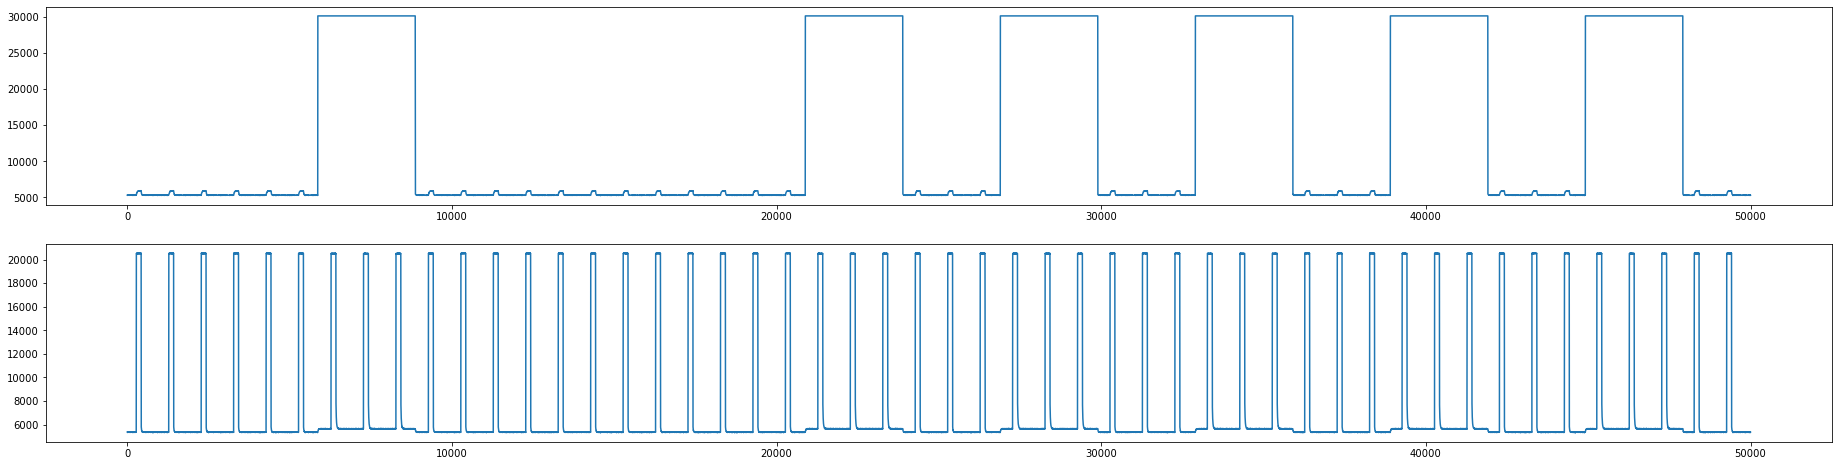

In [322]:
fig, ax = plt.subplots(2, figsize=(32, 8))
aux1 = np.memmap('100_ADC1_0.continuous', dtype=DATA_DT, offset=1024)['samples'].flatten()
aux2 = np.memmap('100_ADC2_0.continuous', dtype=DATA_DT, offset=1024)['samples'].flatten()
ax[0].plot(aux1[50000:100000])
ax[1].plot(aux2[50000:100000])

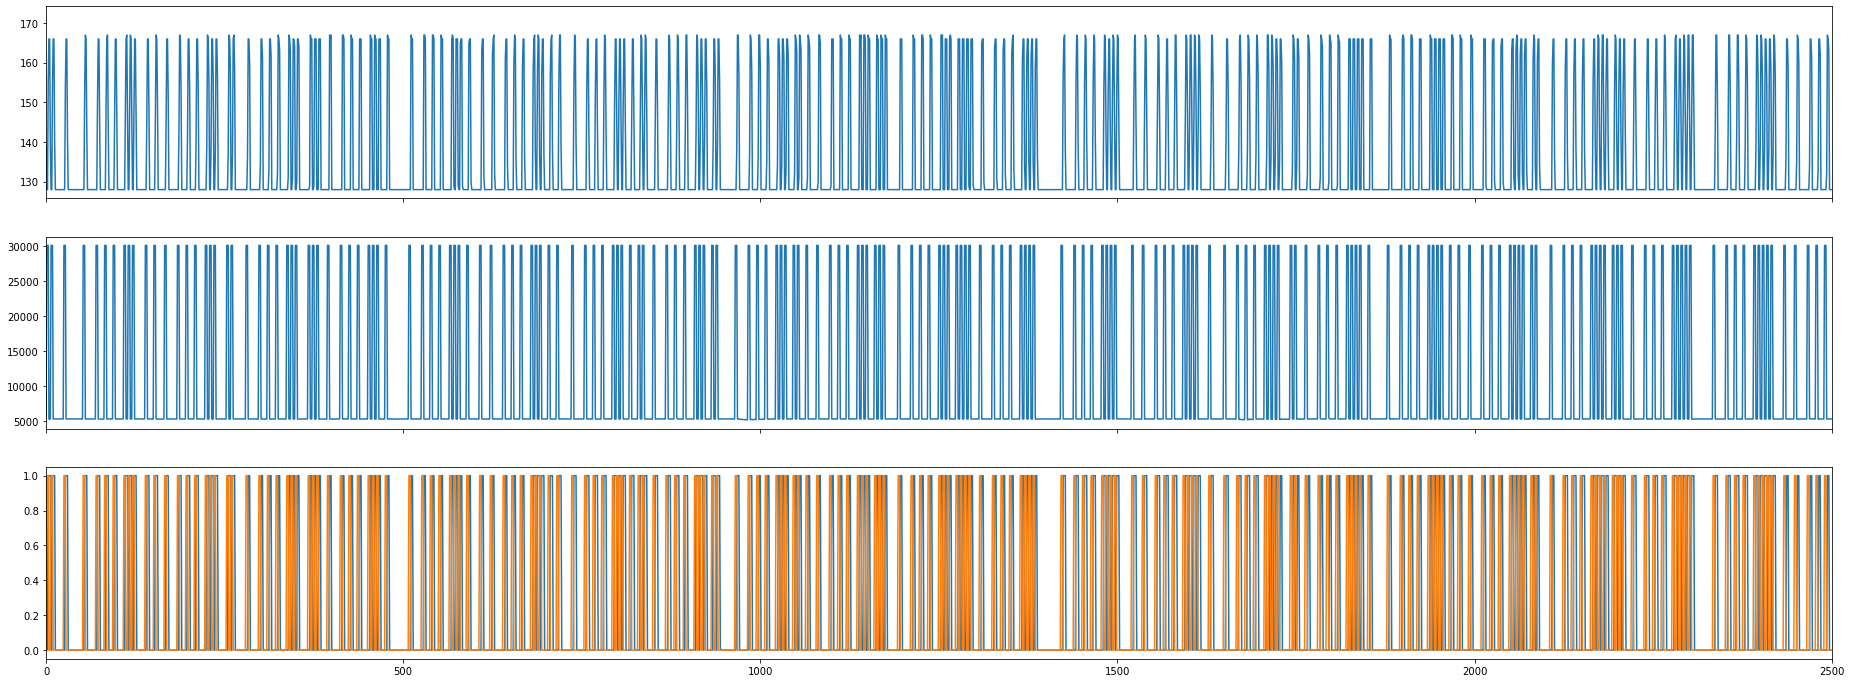

In [361]:
aux1ds = aux1[::1000]
fig, ax = plt.subplots(3, figsize=(32, 12), sharex=True)
ofs = 12000
ax[0].plot(led_yuv[ofs:])
ax[1].plot(aux1ds[ofs+60:])
ax[1].set_xlim(0, 2500)
ax[2].plot(normalize(led_yuv[ofs:])>.2)
ax[2].plot(normalize(aux1ds[ofs+60:].reshape(-1, 1))>.2)

In [362]:
norm_led = normalize(led_yuv).flatten()
norm_aux = normalize(aux1ds.reshape(-1, 1)).flatten()
print(norm_led.shape, norm_aux.shape, norm_aux.dtype)

(19877,) (19873,) float64


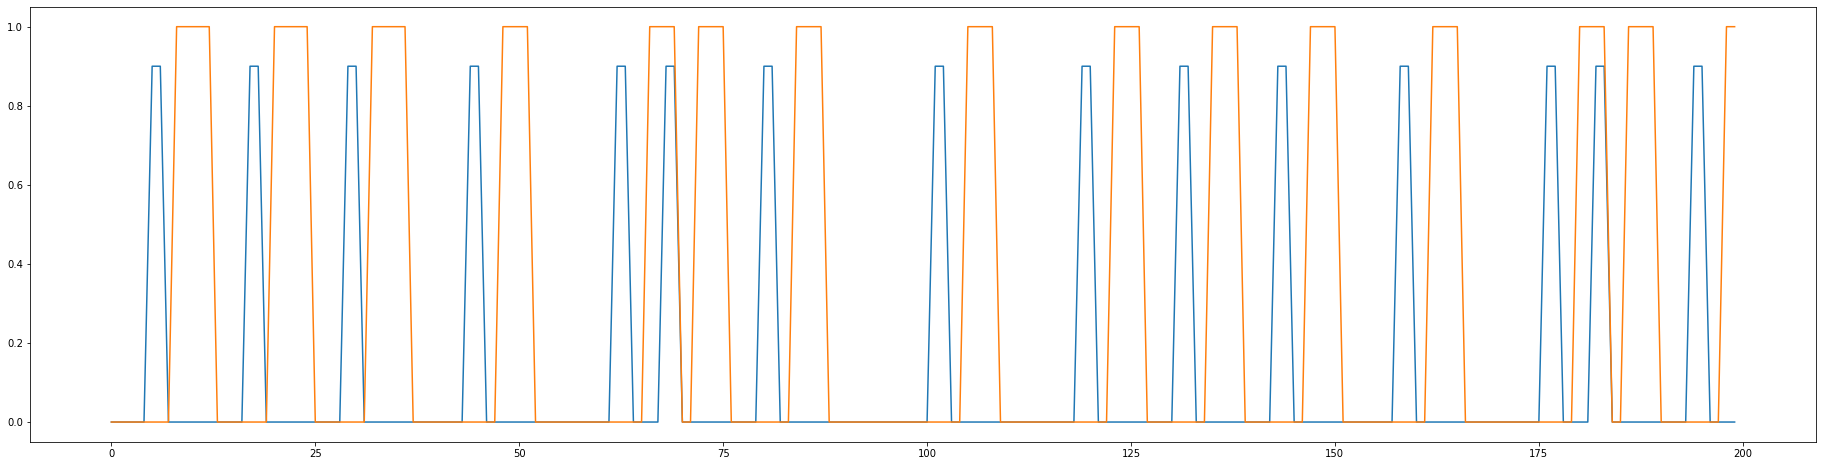

In [363]:
norm_led_thr = (normalize(led_yuv).flatten()>.01).astype(np.double)
norm_aux_thr = (normalize(aux1ds.reshape(-1, 1)).flatten()>.09).astype(np.double)

norm_led_max = maximum_filter1d((norm_led>0.2).astype(np.double), size=2, cval=0, mode='constant')
norm_aux_min = minimum_filter1d((norm_aux>0.2).astype(np.double), size=2, cval=0, mode='constant')

offset = 60
start = 18000
nframes = 200
plt.plot(norm_aux_min[start+offset:start+nframes+offset]*0.9)
plt.plot(norm_led_max[start:start+nframes])

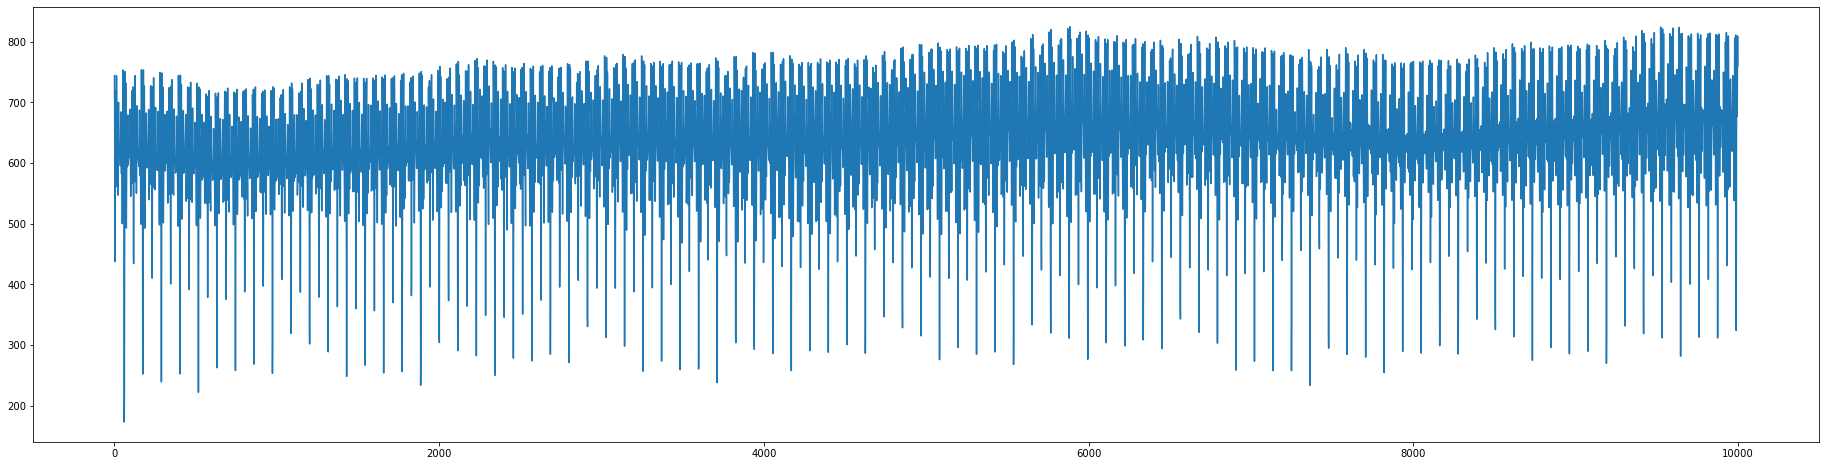

In [312]:
p = []
residuals = []
ws = 2000
nsteps = 10000
woi = norm_led[:ws]
for n in range(nsteps):
    res = np.abs(norm_aux[n:n+ws]-woi)
    cost = np.sum(res)
    p.append(cost)
    residuals.append(res)
plt.plot(p)

60

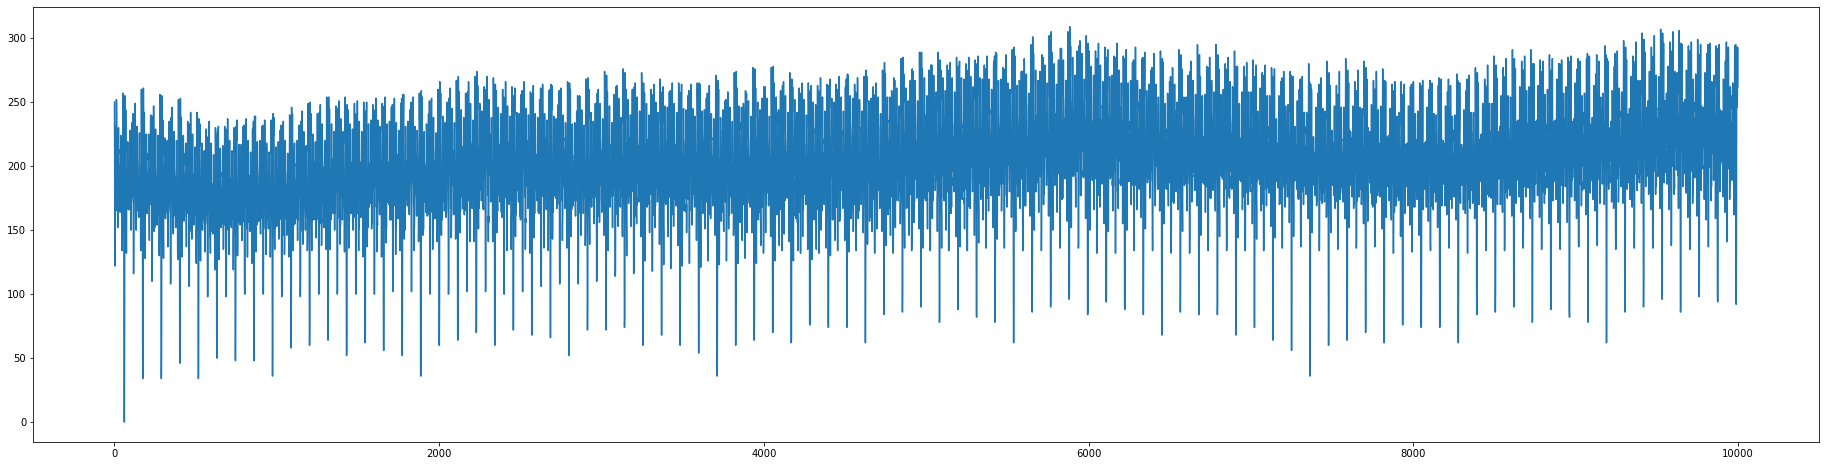

In [313]:
p = []
residuals = []
ws = 2000
nsteps = 10000
woi = norm_led_max[:ws]
for n in range(nsteps):
    res = (norm_aux_max[n:n+ws]-woi)
    cost = np.sum(res>0)
    p.append(cost)
    residuals.append(res)
plt.plot(p)
np.argmin(p)

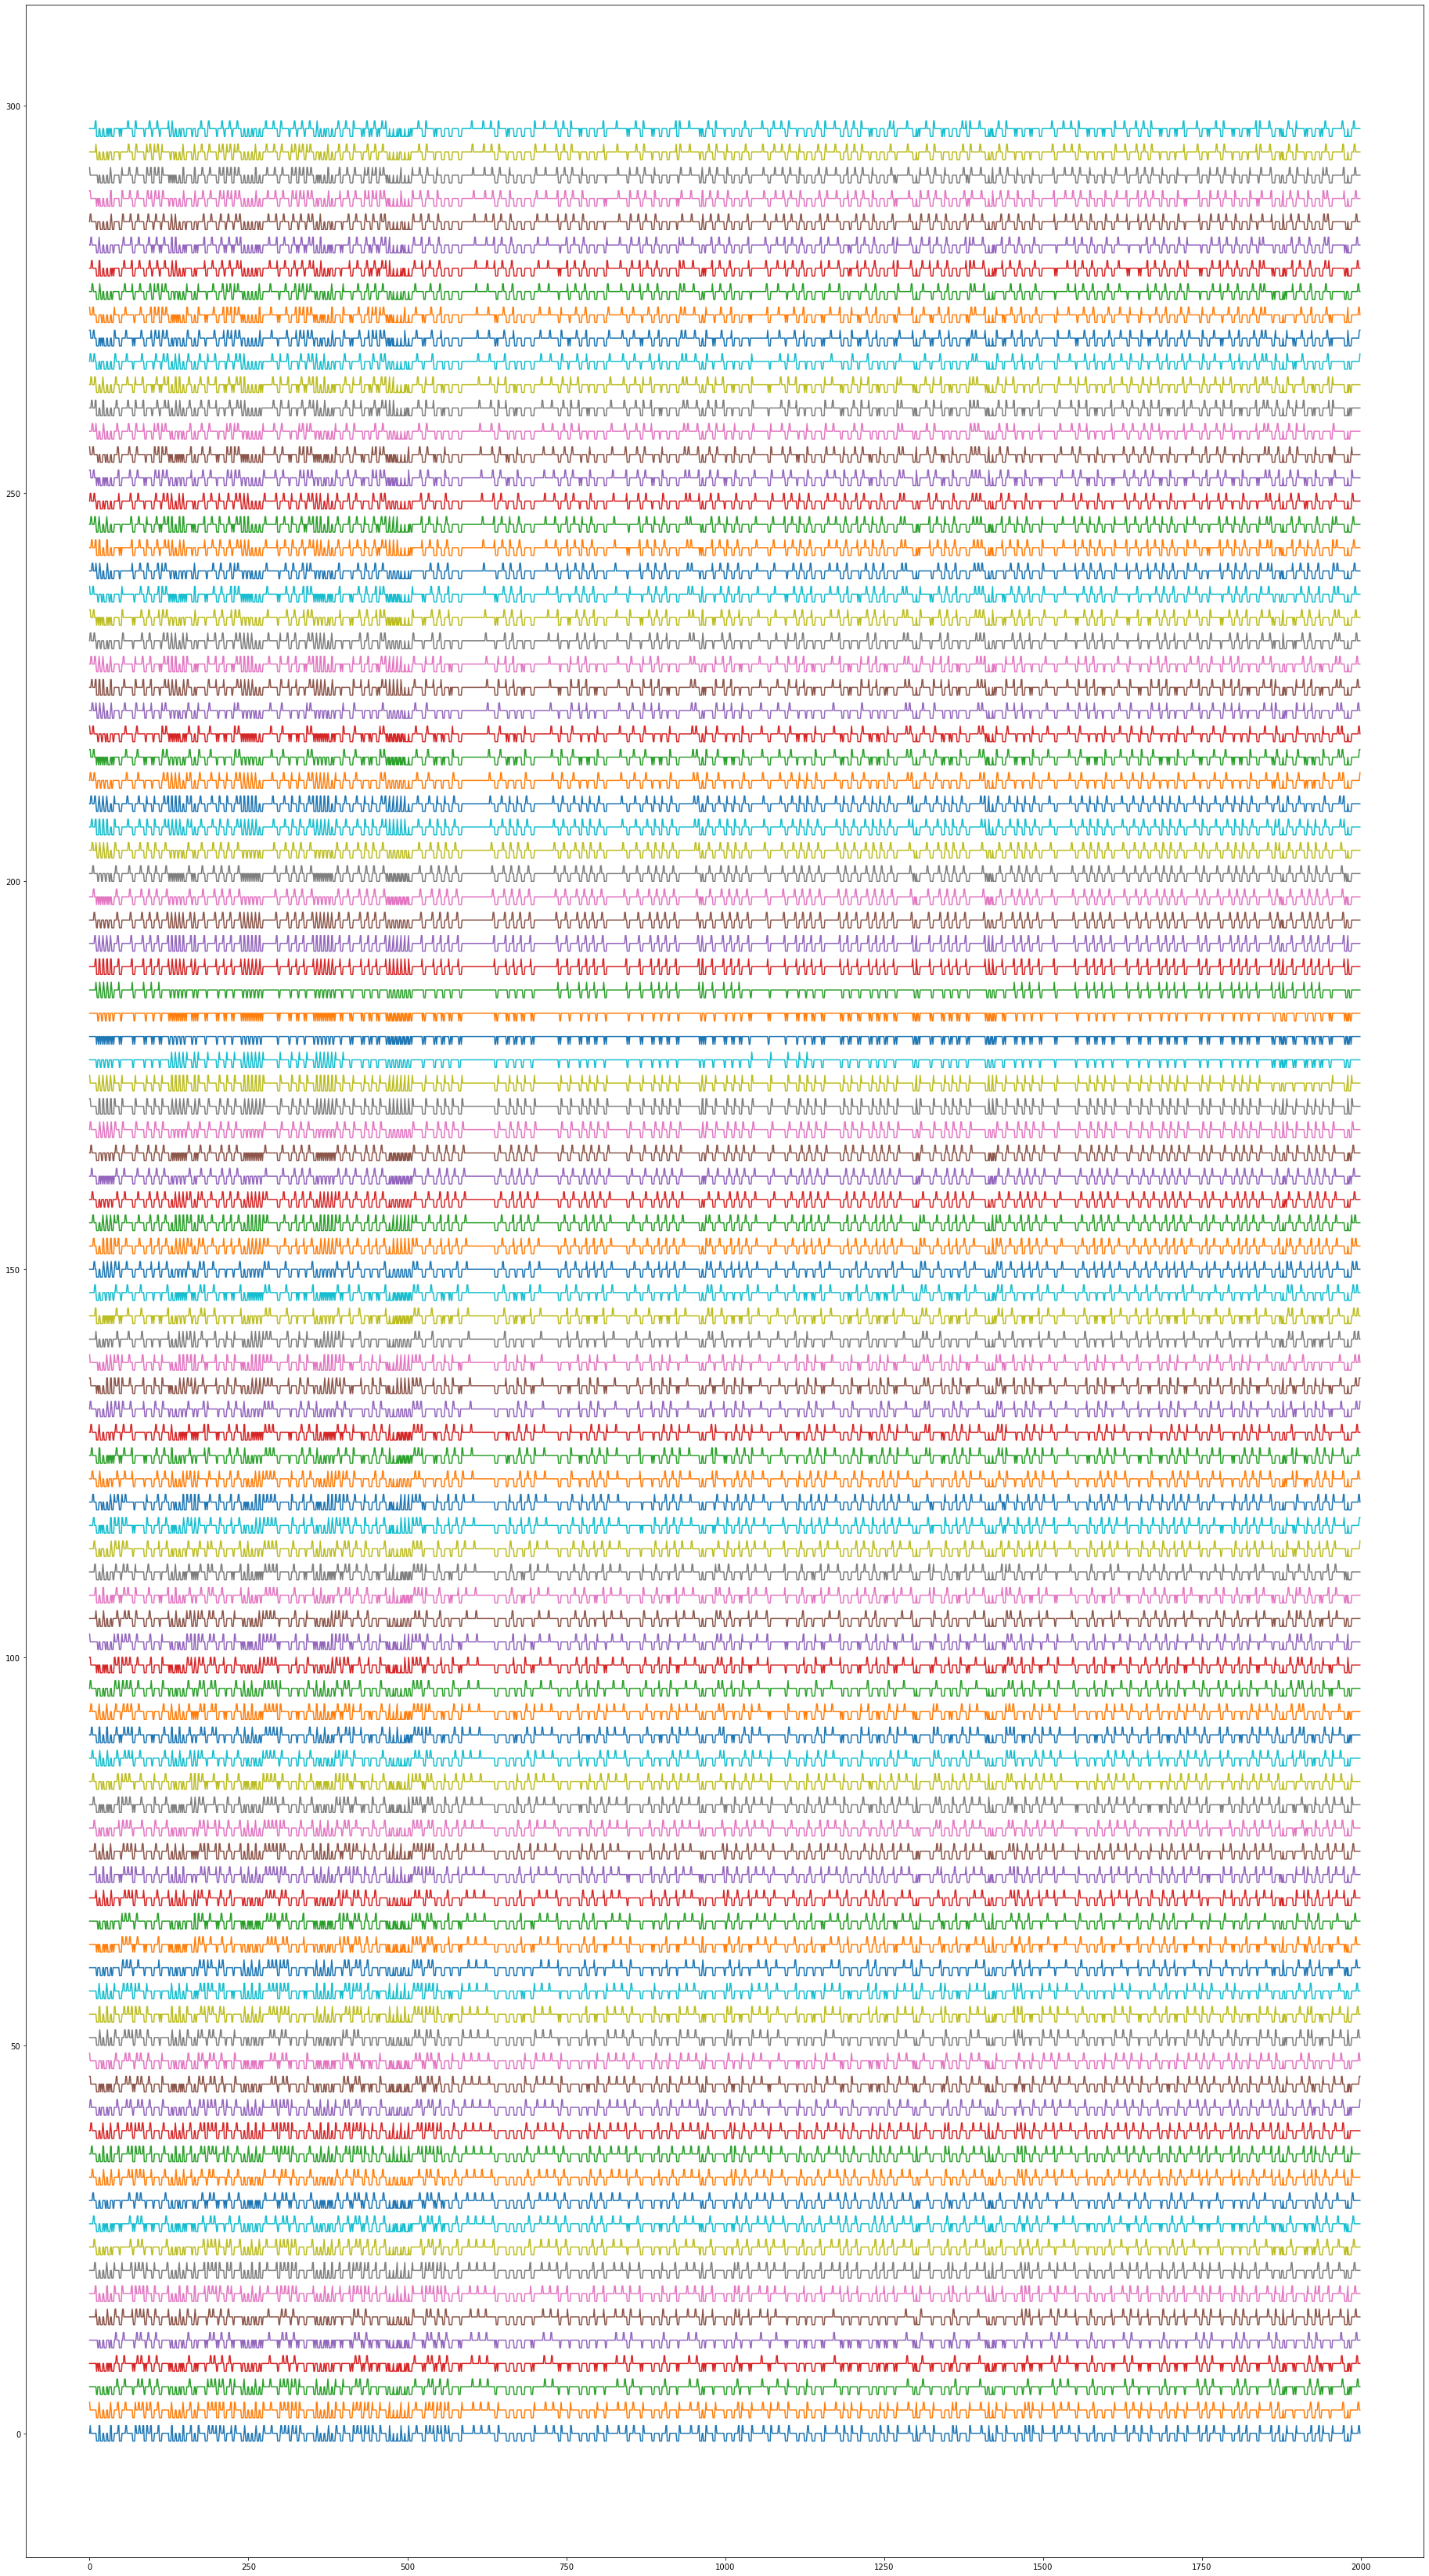

In [309]:
fig, ax = plt.subplots(1, figsize=(32, 60))
for n in range(len(p)):
    ax.plot(residuals[n]+n*3)

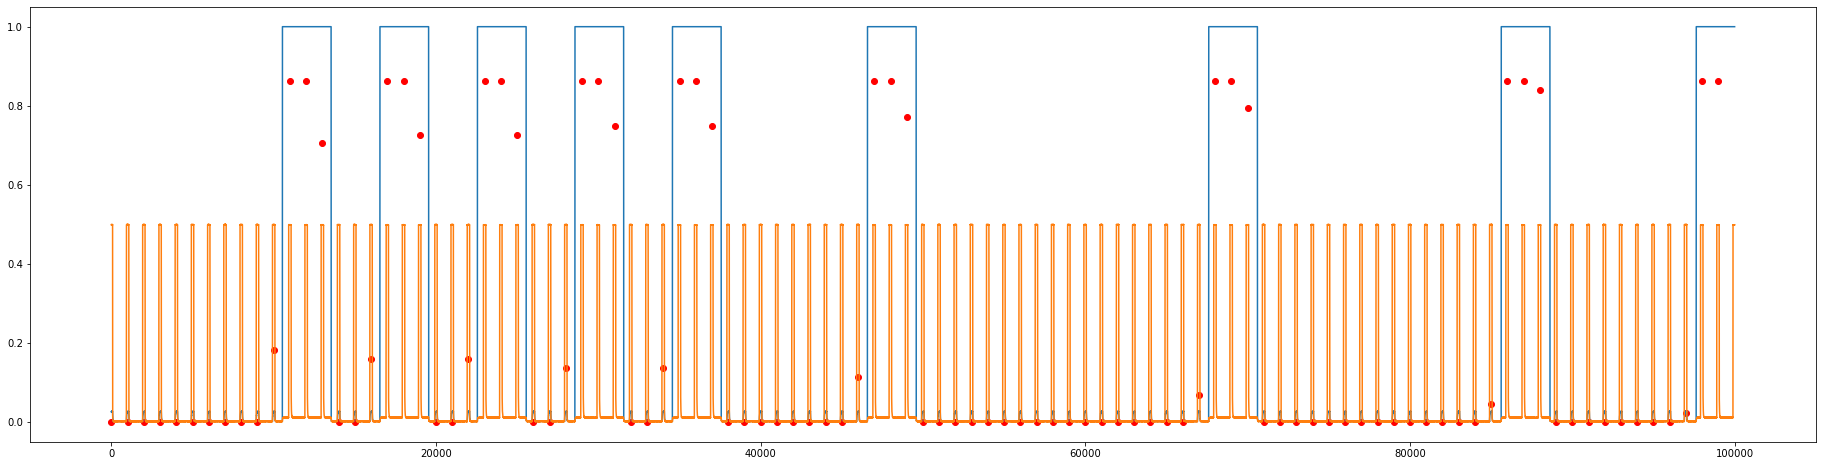

In [405]:
nframes = 100
start = 60350
plt.plot(normalize(aux1[start:start+nframes*1000]))
plt.scatter(np.linspace(0, nframes-1, nframes)*1000, norm_led[:nframes], c='r')
plt.plot(normalize(aux2[start:start+nframes*1000])*0.5)
# plt.axvline(1000, color='k')

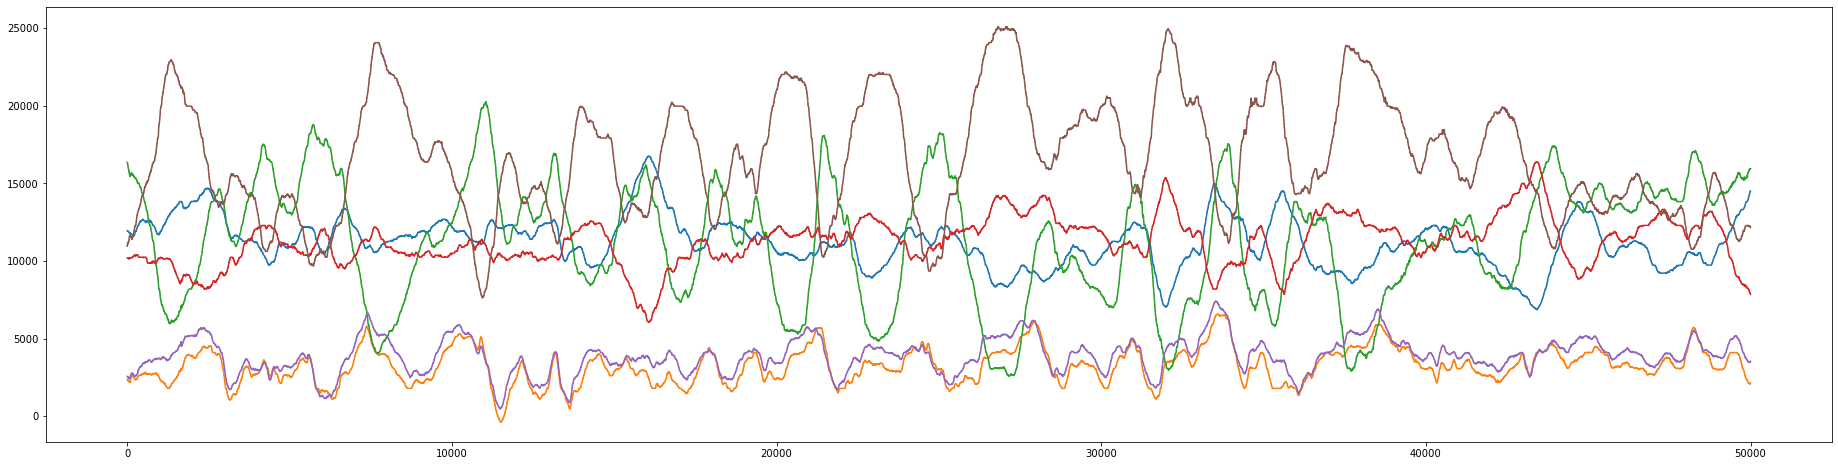

In [410]:
for n in range(6):
    adxx = np.memmap(f'100_AUX{n+1}_0.continuous', dtype=DATA_DT, offset=1024)['samples'].flatten()
    plt.plot(adxx[:50000])